# References:
https://medium.com/@sachinsoni600517/mastering-t-sne-t-distributed-stochastic-neighbor-embedding-0e365ee898ea

https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py



In [1]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data / 255.0
y = mnist.target

In [2]:
# Select 10000 random points
np.random.seed(42)  # For reproducibility
indices = np.random.choice(range(X.shape[0]), size=10000, replace=False)
X_subset = X.iloc[indices]
y_subset = y.iloc[indices]

In [3]:
# Apply PCA for initial dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)

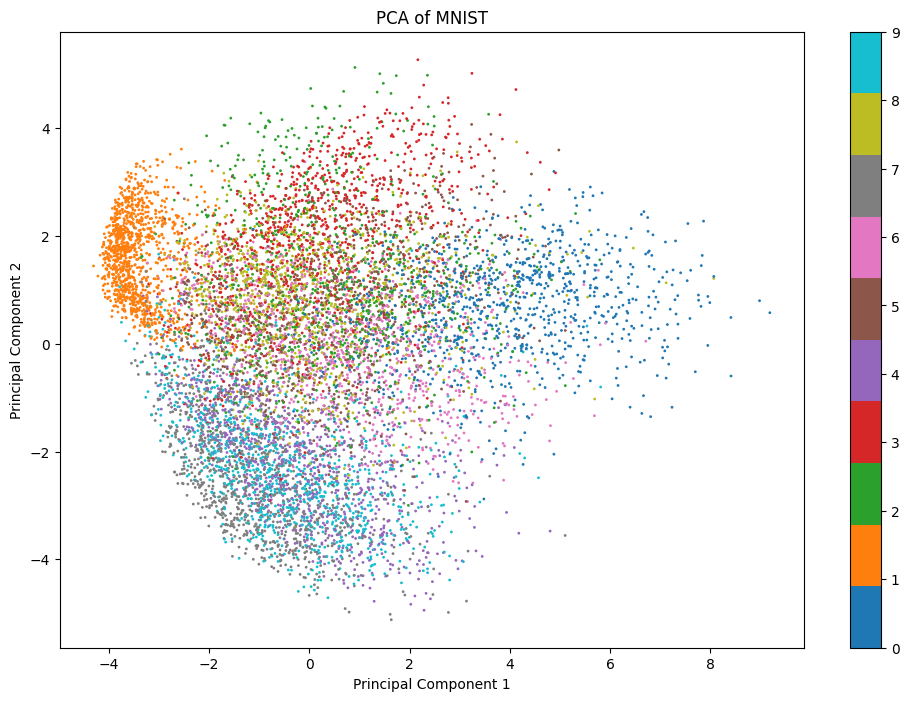

In [4]:
# Plotting with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_subset.astype(int), cmap='tab10', s=1)
plt.colorbar(scatter)
plt.title('PCA of MNIST')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [6]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

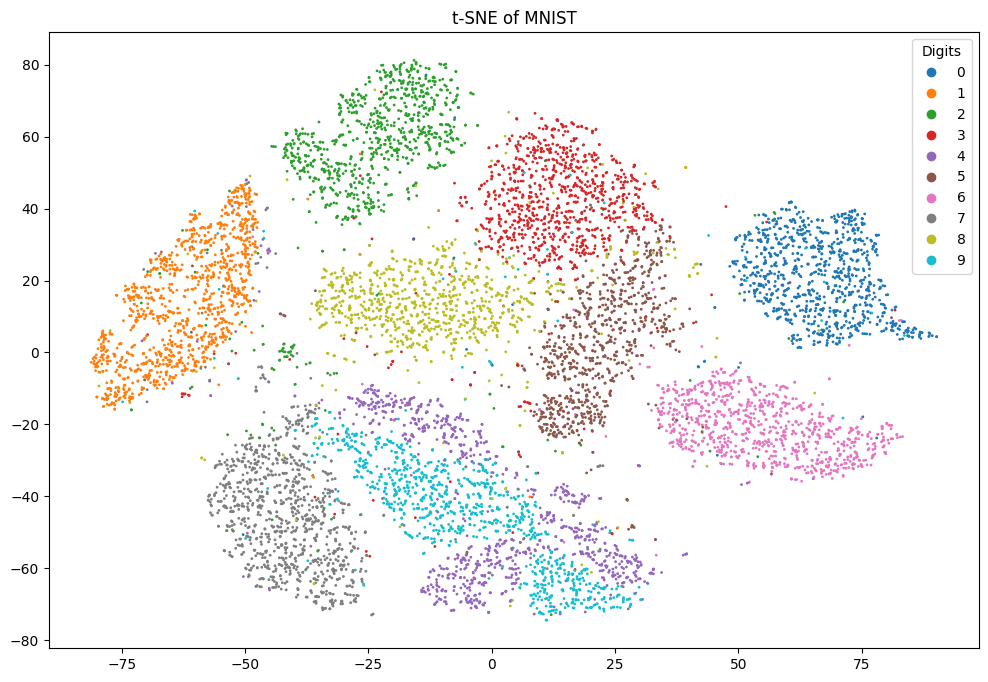

In [9]:
# Plot the result
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset.astype(int), cmap='tab10', s=1)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title('t-SNE of MNIST')
plt.show()

New example

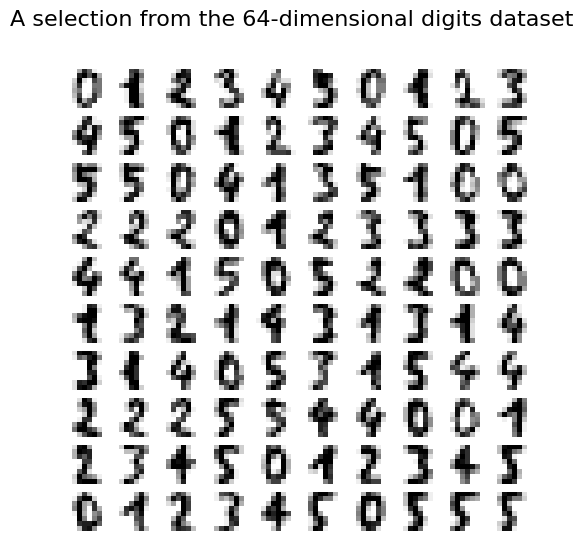

In [10]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbors = 30

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

In [11]:
import numpy as np
from matplotlib import offsetbox

from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

embeddings = {
    "Random projection embedding": SparseRandomProjection(
        n_components=2, random_state=42
    ),
    "Truncated SVD embedding": TruncatedSVD(n_components=2),
    "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
        n_components=2
    ),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "Modified LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="modified"
    ),
    "Hessian LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="hessian"
    ),
    "LTSA LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="ltsa"
    ),
    "MDS embedding": MDS(n_components=2, n_init=1, max_iter=120, n_jobs=2),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=2),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE embedding": TSNE(
        n_components=2,
        max_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
    "NCA embedding": NeighborhoodComponentsAnalysis(
        n_components=2, init="pca", random_state=0
    ),
}

In [13]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y)
    timing[name] = time() - start_time

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Linear Discriminant Analysis embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Modified LLE embedding...
Computing Hessian LLE embedding...
Computing LTSA LLE embedding...
Computing MDS embedding...
Computing Random Trees embedding...
Computing Spectral embedding...
Computing t-SNE embedding...
Computing NCA embedding...


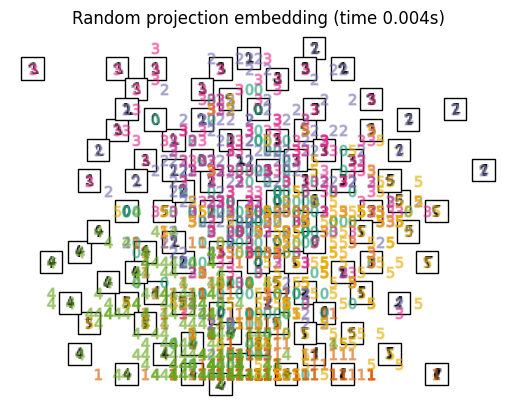

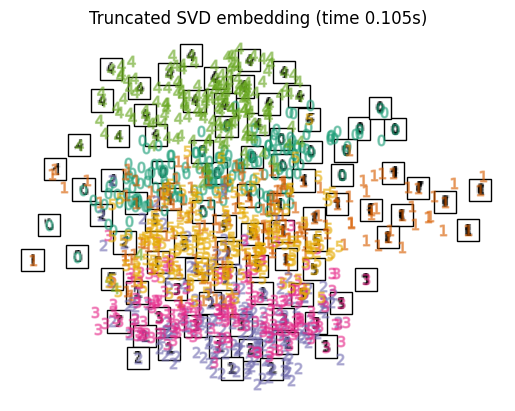

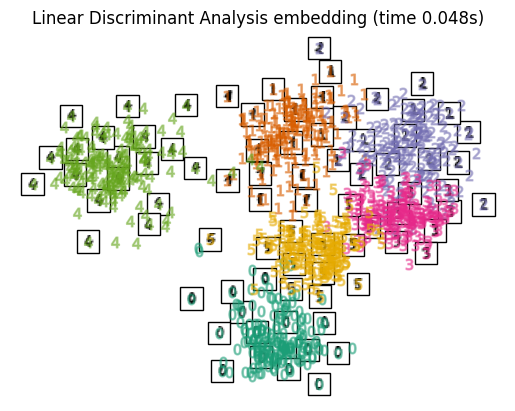

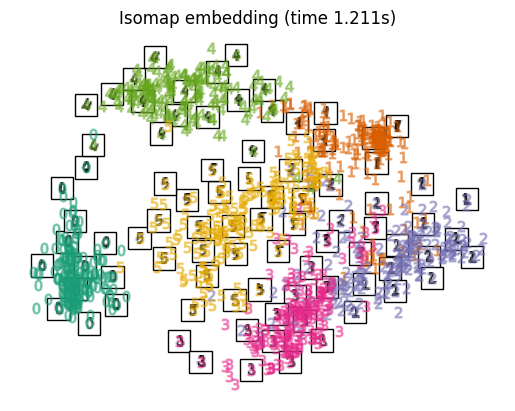

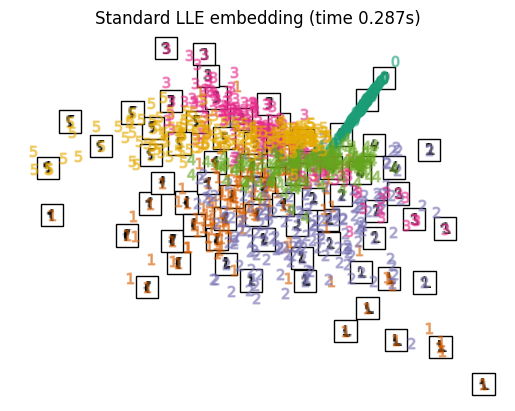

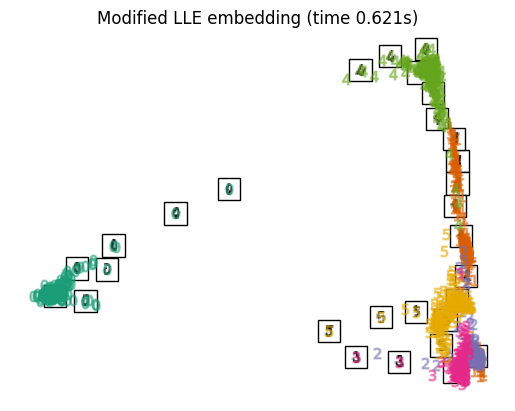

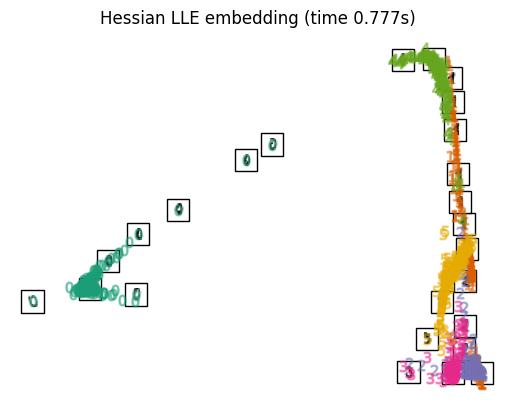

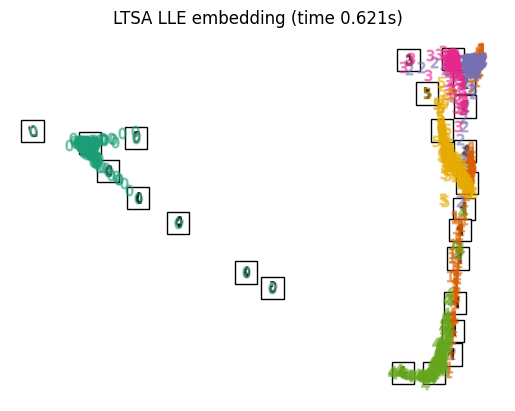

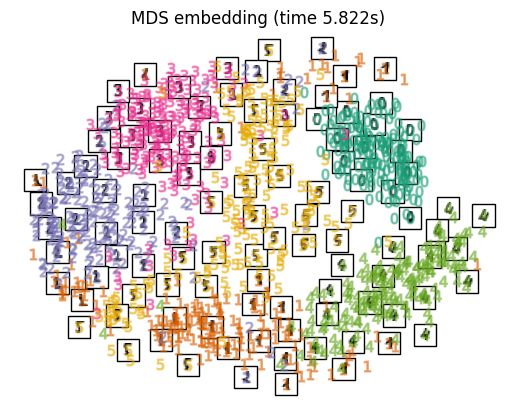

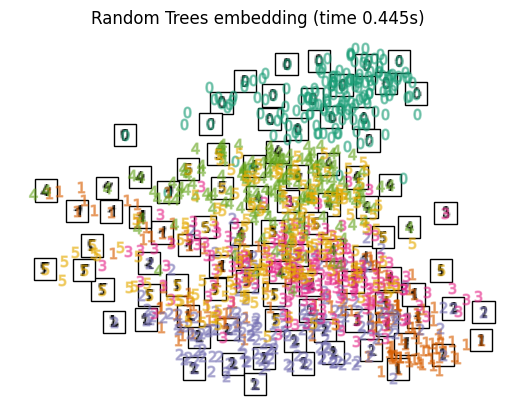

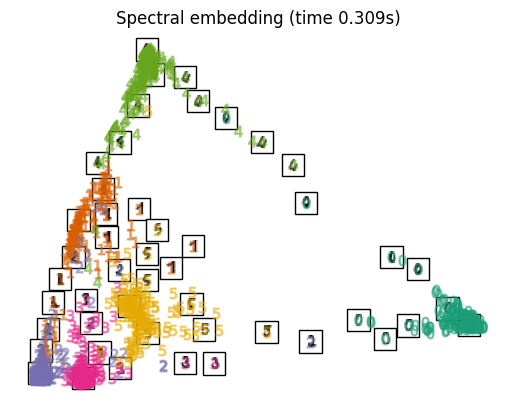

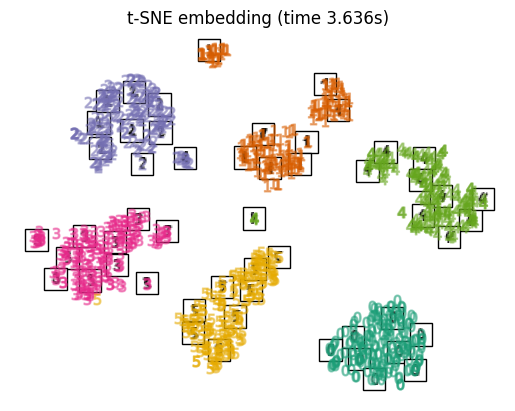

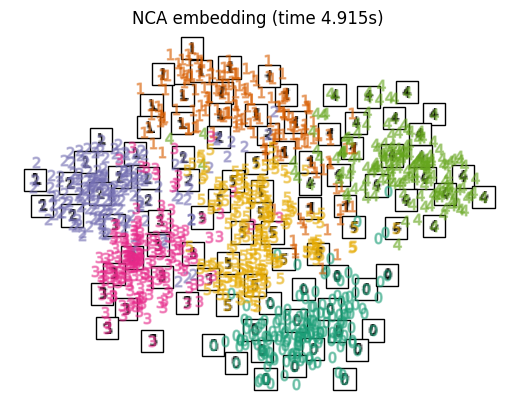

In [14]:
for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title)

plt.show()